In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from baukit import TraceDict


# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
layers = model.config.num_hidden_layers
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.attention") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
num_layers = len(cache_names)
cache_names = [item for sublist in cache_names for item in sublist]
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)

In [4]:
max_seq_length=30 # max length of per data point
from datasets import load_dataset
# dataset_name = "NeelNanda/pile-10k"
dataset_name = "stas/openwebtext-10k"
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: tokenizer(x['text']),
    batched=True
).filter(
    lambda x: len(x['input_ids']) > max_seq_length
).map(
    lambda x: {'input_ids': x['input_ids'][:max_seq_length]}
)

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-28e2aeab2f86f98a.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-6971294dade04414.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-35477b5aec310722.arrow


In [27]:
from activation_dataset import chunk_and_tokenize
from utils import dotdict

# Download the dataset
# This formats it, so every datapoint is max_length tokens long
# The batch size is for loading activations from the LLM, not for inference on the autoencoder
dataset_name="stas/openwebtext-10k"
# cfg.max_length = 64
max_seq_length=32
# cfg.model_batch_size = 4
# d2 = setup_token_data(cfg, tokenizer, model)
# num_tokens = cfg.max_length*cfg.model_batch_size*len(d2)
# print(f"Number of tokens: {num_tokens}")
# num_features, d_model = autoencoder.encoder.shape
dataset = load_dataset(dataset_name, split="train[:300]")
dataset, _ = chunk_and_tokenize(dataset, tokenizer, max_length=max_seq_length)
max_tokens = dataset.num_rows*max_seq_length
print(f"Number of tokens: {max_tokens/1e6:.2f}M")

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)


Number of tokens: 0.33M


In [6]:
import torch as torch
import os
from torch import nn
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, output_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class linear_no_bias(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, output_size, bias=False)
    def forward(self, x):
        x = self.linear(x)
        return x

num_layers = 5
dir = "sparse_weights"
linear_name = "linear_weights_no_bias_{layer}.pt"
mlp_name = "mlp_weights_no_bias_{layer}.pt"
linear_sparse_connections = []
mlp_sparse_connections = []
for layer in range(num_layers):
    linear_sparse_connections.append(torch.load(os.path.join(dir, linear_name.format(layer=layer))))
    mlp_sparse_connections.append(torch.load(os.path.join(dir, mlp_name.format(layer=layer))))

In [7]:
# Load in the features indices
# Note: linear & MLP features are a subet of alive features, not total features
import pickle
with open("linear_features.pkl", "rb") as f:
    linear_features = pickle.load(f)
with open("mlp_features.pkl", "rb") as f:
    mlp_features = pickle.load(f)
with open("alive_features.pkl", "rb") as f:
    alive_features_ind = pickle.load(f)

In [8]:
lw = linear_sparse_connections[layer].linear.weight
f_out, f_in = lw.shape
# largest_feature_weights, largest_weight_ind = lw.squeeze().abs().topk(5, dim=0)
largest_feature_weights, largest_weight_ind = lw.flatten().abs().topk(5)
print(largest_feature_weights)
row_ind = largest_weight_ind // f_in
col_ind = largest_weight_ind % f_in
print(row_ind, col_ind)

tensor([1.4919, 1.2912, 1.0531, 0.9108, 0.8786], grad_fn=<TopkBackward0>)
tensor([320, 399, 359, 422, 335]) tensor([1261, 2174, 2999,  230, 2221])


In [9]:
# mlp_features[layer].nonzero()[0]
lw = mlp_sparse_connections[layer].linear2.weight
lw[-1].topk(10)

torch.return_types.topk(
values=tensor([0.6132, 0.5570, 0.5376, 0.5260, 0.5153, 0.5073, 0.4836, 0.4815, 0.4751,
        0.4730], grad_fn=<TopkBackward0>),
indices=tensor([ 203, 2803, 1383, 2780,  721, 1955, 1444, 1598,  764, 2572]))

In [10]:
find_ind = [870, 706, 643, 35, 752]
threshold = 0.1
for layer_ind, find_index in enumerate(find_ind):
    ind = mlp_features[layer_ind].nonzero()[0].tolist().index(find_index)
    above_threshold = (mlp_sparse_connections[layer_ind].linear2.weight[ind] > threshold).sum()
    # get the indices that are not the indices
    length = mlp_sparse_connections[layer_ind].linear2.weight.shape[0]
    selected_indices = torch.arange(length) != ind
    above_threshold_not_outlier = (mlp_sparse_connections[layer_ind].linear2.weight[selected_indices] > threshold).sum(1).float().mean().item()
    not_indice_above_threshold= (mlp_sparse_connections[layer_ind].linear2.weight[ind] > threshold)
    print(f"layer {layer_ind}: {above_threshold} vs {above_threshold_not_outlier:.0f}")

layer 0: 74 vs 4
layer 1: 42 vs 13
layer 2: 25 vs 6
layer 3: 36 vs 5
layer 4: 112 vs 9


In [1]:
find_ind = [870, 706, 643, 35, 752]
threshold = -0.1
for layer_ind, find_index in enumerate(find_ind):
    ind = mlp_features[layer_ind].nonzero()[0].tolist().index(find_index)
    print(ind)
    above_threshold = (mlp_sparse_connections[layer_ind].linear2.weight[ind] < threshold).sum()
    # get the indices that are not the indices
    length = mlp_sparse_connections[layer_ind].linear2.weight.shape[0]
    selected_indices = torch.arange(length) != ind
    above_threshold_not_outlier = (mlp_sparse_connections[layer_ind].linear2.weight[selected_indices] < threshold).sum(1).float().mean().item()
    not_indice_above_threshold= (mlp_sparse_connections[layer_ind].linear2.weight[ind] > threshold)
    print(f"layer {layer_ind}: {above_threshold} vs {above_threshold_not_outlier:.0f}")

NameError: name 'mlp_features' is not defined

In [54]:
threshold = 0.1
for layer_ind, find_index in enumerate(find_ind):
    val, ind = (mlp_sparse_connections[layer_ind].linear2.weight> threshold).sum(1).topk(5)
    median = (mlp_sparse_connections[layer_ind].linear2.weight> threshold).sum(1).float().median().item()
    print(f"layer {layer_ind}: {val} vs {median:.0f}")

layer 0: tensor([74, 51, 27, 14, 13]) vs 3
layer 1: tensor([71, 48, 42, 42, 40]) vs 4
layer 2: tensor([25, 18, 16, 14, 12]) vs 4
layer 3: tensor([36, 24, 12,  9,  8]) vs 4
layer 4: tensor([112,  19,  11,  10,   9]) vs 9


In [55]:
threshold = -0.1
for layer_ind, find_index in enumerate(find_ind):
    val, ind = (mlp_sparse_connections[layer_ind].linear2.weight < threshold).sum(1).topk(5)
    median = (mlp_sparse_connections[layer_ind].linear2.weight < threshold).sum(1).float().median().item()
    print(f"layer {layer_ind}: {val} vs {median:.0f}")

layer 0: tensor([36, 34, 14,  7,  7]) vs 0
layer 1: tensor([32, 31, 28, 22, 14]) vs 0
layer 2: tensor([14,  3,  3,  3,  2]) vs 0
layer 3: tensor([15,  5,  1,  1,  1]) vs 0
layer 4: tensor([10,  0,  0,  0,  0]) vs 0


In [49]:
above_threshold_not_outlier

torch.return_types.topk(
values=tensor([112,  19,  11]),
indices=tensor([8, 6, 1]))

In [13]:
find_ind = [1,0,0,0,0]
for layer_ind, find_index in enumerate(find_ind):
    ind = 0
    print(f"layer {layer_ind}: {mlp_sparse_connections[layer_ind].linear2.weight[ind].topk(10).values}")

layer 0: tensor([0.0498, 0.0412, 0.0342, 0.0314, 0.0263, 0.0176, 0.0169, 0.0119, 0.0077,
        0.0062], grad_fn=<TopkBackward0>)
layer 1: tensor([4.7935e-01, 2.8848e-01, 2.0765e-01, 3.0066e-02, 1.0669e-03, 7.2536e-04,
        5.0014e-04, 4.6772e-04, 4.1492e-04, 4.1314e-04],
       grad_fn=<TopkBackward0>)
layer 2: tensor([0.4157, 0.3570, 0.2358, 0.1398, 0.0039, 0.0038, 0.0038, 0.0037, 0.0034,
        0.0034], grad_fn=<TopkBackward0>)
layer 3: tensor([0.5466, 0.3597, 0.0055, 0.0028, 0.0020, 0.0012, 0.0012, 0.0012, 0.0011,
        0.0011], grad_fn=<TopkBackward0>)
layer 4: tensor([0.1605, 0.1496, 0.1467, 0.1464, 0.1294, 0.1178, 0.1124, 0.0856, 0.0814,
        0.0781], grad_fn=<TopkBackward0>)


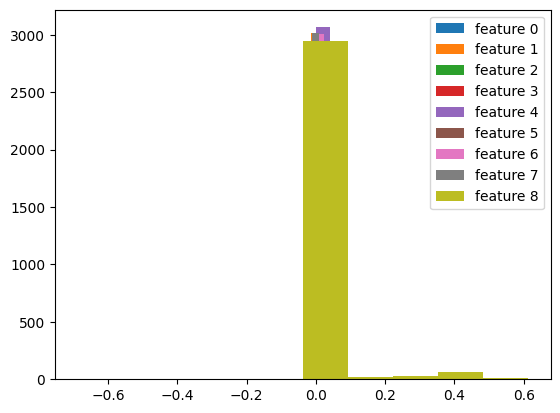

In [17]:
from matplotlib import pyplot as plt
layer = 4
# plot a histogram of weights for every feature in the mlp
mlp_w2 = mlp_sparse_connections[layer_ind].linear2.weight
mlp_w2
plt.legend()
plt.show()

In [49]:
mlp_features[1].nonzero()[0].shape, mlp_sparse_connections[layer_ind].linear2.weight.shape

((31,), torch.Size([26, 3072]))

In [52]:
linear_sparse_connections[layer].linear.weight.topk(5)

torch.Size([914, 5])

In [7]:
'''layer 0: torch.return_types.topk(
values=tensor([0.3343, 0.2043, 0.0410, 0.0331, 0.0198]),
indices=tensor([ 869,  667,  709, 1061,  934]))
layer 1: torch.return_types.topk(
values=tensor([2.6648, 2.6510, 2.3523, 1.4538, 0.2790]),
indices=tensor([716, 306, 598, 397,  66]))
layer 2: torch.return_types.topk(
values=tensor([0.2839, 0.0382, 0.0376, 0.0188, 0.0174]),
indices=tensor([ 631,   74, 1019, 1072,  230]))
layer 3: torch.return_types.topk(
values=tensor([0.4628, 0.0553, 0.0442, 0.0252, 0.0201]),
indices=tensor([  35, 1493,   37, 1390, 1244]))
layer 4: torch.return_types.topk(
values=tensor([1.3722e+01, 4.6175e-02, 1.7231e-02, 1.0577e-02, 2.8266e-03]),
indices=tensor([758, 136, 211, 481, 349]))'''

'''layer 0: torch.return_types.topk(
values=tensor([0.1401, 0.0860, 0.0159, 0.0150, 0.0125]),
indices=tensor([ 870,  671,  502,  787, 1035]))
layer 1: torch.return_types.topk(
values=tensor([0.3370, 0.3324, 0.2910, 0.1682, 0.1069]),
indices=tensor([706, 303, 594, 392,  70]))
layer 2: torch.return_types.topk(
values=tensor([0.0456, 0.0163, 0.0122, 0.0101, 0.0069]),
indices=tensor([ 643, 1082,  470, 1193,  396]))
layer 3: torch.return_types.topk(
values=tensor([0.0529, 0.0134, 0.0106, 0.0106, 0.0099]),
indices=tensor([  35, 1492,   37, 1390, 1243]))
layer 4: torch.return_types.topk(
values=tensor([1.5555, 0.0116, 0.0052, 0.0040, 0.0038]),
indices=tensor([752, 348,  63, 684, 228]))'''

'layer 0: torch.return_types.topk(\nvalues=tensor([0.1401, 0.0860, 0.0159, 0.0150, 0.0125]),\nindices=tensor([ 870,  671,  502,  787, 1035]))\nlayer 1: torch.return_types.topk(\nvalues=tensor([0.3370, 0.3324, 0.2910, 0.1682, 0.1069]),\nindices=tensor([706, 303, 594, 392,  70]))\nlayer 2: torch.return_types.topk(\nvalues=tensor([0.0456, 0.0163, 0.0122, 0.0101, 0.0069]),\nindices=tensor([ 643, 1082,  470, 1193,  396]))\nlayer 3: torch.return_types.topk(\nvalues=tensor([0.0529, 0.0134, 0.0106, 0.0106, 0.0099]),\nindices=tensor([  35, 1492,   37, 1390, 1243]))\nlayer 4: torch.return_types.topk(\nvalues=tensor([1.5555, 0.0116, 0.0052, 0.0040, 0.0038]),\nindices=tensor([752, 348,  63, 684, 228]))'

In [14]:
def linear_to_original(ind, layer, linear_or_mlp_features):
    linear_to_alive_map = linear_or_mlp_features[layer].nonzero()[0]
    alive_to_original_map = alive_features_ind[layer].nonzero()[:,0]
    return alive_to_original_map[linear_to_alive_map[ind]]
# find_ind = [870, 671,  502,  787, 1035]
# find_ind = [706, 303, 594, 392,  70]
# find_ind = [643, 1082,  470, 1193,  396]
# find_ind = [35, 1492,   37, 1390, 1243]
find_ind = [752, 348,  63, 684, 228]
layer = 4
indices = []
for find_index in find_ind:
    ind = mlp_features[layer].nonzero()[0].tolist().index(find_index)
    indices.append(linear_to_original(ind, layer, mlp_features).item())
print(indices)

[2819, 1372, 251, 2562, 885]


In [31]:
from alpha_utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

####################################################################################################################################################################
# Other way around: restricted linear indices -> alive indices -> original indices
def linear_to_original(ind, layer, linear_or_mlp_features):
    linear_to_alive_map = linear_or_mlp_features[layer].nonzero()[0]
    alive_to_original_map = alive_features_ind[layer].nonzero()[:,0]
    return alive_to_original_map[linear_to_alive_map[ind]]
# Figure out Features
layer = 0
def linear_to_original(ind, layer, linear_or_mlp_features):
    linear_to_alive_map = linear_or_mlp_features[layer].nonzero()[0]
    alive_to_original_map = alive_features_ind[layer].nonzero()[:,0]
    return alive_to_original_map[linear_to_alive_map[ind]]
find_ind = [870, 671,  502,  787, 1035]
# find_ind = [706, 303, 594, 392,  70]
# find_ind = [643, 1082,  470, 1193,  396]
# find_ind = [35, 1492,   37, 1390, 1243]
# find_ind = [752, 348,  63, 684, 228]
indices = []
for find_index in find_ind:
    ind = mlp_features[layer].nonzero()[0].tolist().index(find_index)
    indices.append(linear_to_original(ind, layer, mlp_features).item())
print(indices)

# setting = "linear"
setting = "mlp"
k = 3
cache_names_layer = cache_names[layer*2:layer*2+2]
autoencoders_layer = autoencoders[layer*2:layer*2+2]
# Index for output (mlp_out)
# linear: 359, 448, 404, 472, 377
output_index_restricted = 8
if(setting == "linear"):
    output_index = linear_to_original(output_index_restricted, layer, linear_features)
    input_weights, input_index = linear_sparse_connections[layer].linear.weight.topk(k)
if(setting == "mlp"):    
    output_index = linear_to_original(output_index_restricted, layer, mlp_features)
    input_weights, input_index = mlp_sparse_connections[layer].linear2.weight.topk(k)
    # input_index, input_weights = mlp_sparse_connections[layer].linear.weight.topk(k)

input_index = input_index[output_index_restricted]
input_weights = input_weights[output_index_restricted]
# output_index = mlp_features[layer].nonzero()[0][output_index_restricted]
# output_index = 835
# features_all = [input_index.tolist(), [output_index]]
features_all = [[], indices]

# Now view the features
# 0 is input feature (ie {} residual stream)
# 1 is output feature (ie mlp_out)
print(f"Weights:{input_weights}")
ind_num = 1
for ind_num in range(1, -1, -1):
    if(ind_num == 0):
        print("Input feature")
    else:
        print("Output feature")
    features = features_all[ind_num]
    cache_name = cache_names_layer[ind_num]
    autoencoder = autoencoders_layer[ind_num]

    # ALSO
    # 1. Look through linear_sparse_connections[layer].linear.weight. for especially large weights
    # 2. Visualize both at once
    ###################################################################################################################################################


    num_feature_datapoints = 5
    dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

    # features = [1,2,3,4,5,6,7,8,9,10]
    # features = [5,6]
    # features = None
    num_features = 30
    # feature = 0
    input_setting = "input_only"
    model_type="causal"
    ablate_context = True

    for feature in features:
        # Check if feature is dead (<10 activations)
        dead_threshold = 1
        # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
        if(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
            print(f"Feature {feature} is dead")
            # Go to next feature
            continue
        print(f"Feature {feature} is alive")
        uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
        # uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="max")
        text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
        # get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
        if(input_setting == "input_only"):
            # Calculate logit diffs on this feature for the full_token_list
            logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences", model_type=model_type)
            # save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type)
            save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type, show=True)
            # all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, cache_name, autoencoder, feature, max_ablation_length=30)
            # save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
        else:
            logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
            _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
            get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
            save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
        # if(ablate_context ==True):
        #     all_changed_activations = ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20)
        #     save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
        # combine_images(feature, setting=input_setting, ablate_context=ablate_context)
        feature += 1

[2507, 1910, 1404, 2227, 2960]
Weights:tensor([0.3598, 0.3579, 0.3552], grad_fn=<SelectBackward0>)
Output feature


100%|██████████| 320/320 [00:10<00:00, 29.33it/s]


Feature 2507 is alive


/root/sparse_coding/alpha_utils_interp.py:387: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_tok = torch.tensor(dataset[md]["input_ids"])


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


Feature 1910 is alive


/root/sparse_coding/alpha_utils_interp.py:387: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_tok = torch.tensor(dataset[md]["input_ids"])


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


Feature 1404 is alive


/root/sparse_coding/alpha_utils_interp.py:387: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_tok = torch.tensor(dataset[md]["input_ids"])


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


Feature 2227 is alive


/root/sparse_coding/alpha_utils_interp.py:387: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_tok = torch.tensor(dataset[md]["input_ids"])


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


Feature 2960 is alive


/root/sparse_coding/alpha_utils_interp.py:387: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_tok = torch.tensor(dataset[md]["input_ids"])


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


Input feature


100%|██████████| 320/320 [00:11<00:00, 28.68it/s]
